In [ ]:
#IMPORT PACKAGES
from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import utils
from torchvision.io import read_image
import torchvision.transforms as T
import random
from torch import Tensor
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split


#access files stored in drive - you will have to give Google Drive permission to access your files in your Google Drive
#add 'Team 1' folder as a shortcut to your Drive, then rename the folder to 'Team_1' (spaces are problematic in file paths)
from google.colab import drive
drive.mount('/content/gdrive')

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode

Mounted at /content/gdrive


In [ ]:
#CUSTOM DATASET CLASS DATASET
class HAM10000(Dataset):
  """HAM10000 Dataset"""

  def __init__(self, csv_file, img_dir, transform=None, target_transform=None):
    """
    Args:
      csv_file (string): Path to the csv file with the metadata/labels for images.
      img_dir (string): Directory with all the images.
      transform (callable, optional): Optional transform to be applied
          on the image of a sample.
      target_transform (callable, optional): Optional transform to be
          applied on the features of the sample.
    """
    self.img_labels = pd.read_csv(csv_file)
    self.img_dir = img_dir
    self.transform = transform
    self.target_transform = target_transform

  def __len__(self):
    return len(self.img_labels)

  def __getitem__(self, index):
    #get image
    img_name = os.path.join(self.img_dir, (self.img_labels['image_id'][index] + '.jpg'))
    image = read_image(img_name)/255
    image = torch.tensor(image, dtype=torch.float32)


    #get metadata
    label = self.img_labels['label'][index]
    # label = np.array([label], dtype=np.int8)
    # label = torch.from_numpy(label.flatten())

    gender = self.img_labels['sex'][index]


    # #if transforms are to be performed on the sample, this will trigger them
    if self.transform:
      image = self.transform(image)
    if self.target_transform:
      label = self.target_transform(label)
    if self.target_transform:
      fitzscale = self.target_transform(fitzscale)

    return image, label, gender

In [ ]:
image_size = 64
weight_decay = 8e-9
beta1 = 0.5
beta2 = 0.999

In [ ]:
HAM10000_meta = pd.read_csv('/content/gdrive/MyDrive/CSC2529/HAM10000_metadata')

In [ ]:
HAM10000_meta

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,vidir_modern
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,vidir_modern
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,vidir_modern
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,vidir_modern
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,vidir_modern
...,...,...,...,...,...,...,...,...
10010,HAM_0002867,ISIC_0033084,akiec,histo,40.0,male,abdomen,vidir_modern
10011,HAM_0002867,ISIC_0033550,akiec,histo,40.0,male,abdomen,vidir_modern
10012,HAM_0002867,ISIC_0033536,akiec,histo,40.0,male,abdomen,vidir_modern
10013,HAM_0000239,ISIC_0032854,akiec,histo,80.0,male,face,vidir_modern


We sample two diseases, melanoma and benign keratosis from the entire data

In [ ]:
HAM_male_mel = HAM10000_meta[(HAM10000_meta.dx == 'mel') & (HAM10000_meta.sex == "male")]
HAM_female_mel = HAM10000_meta[(HAM10000_meta.dx == 'mel') & (HAM10000_meta.sex == "female")]

HAM_male_bkl = HAM10000_meta[(HAM10000_meta.dx == 'bkl') & (HAM10000_meta.sex == "male")]
HAM_female_bkl = HAM10000_meta[(HAM10000_meta.dx == 'bkl') & (HAM10000_meta.sex == "female")]

In [ ]:
HAM_male_mel = HAM_male_mel[['image_id', 'dx', 'sex']]
HAM_female_mel = HAM_female_mel[['image_id', 'dx', 'sex']]

HAM_male_bkl = HAM_male_bkl[['image_id', 'dx', 'sex']]
HAM_female_bkl = HAM_female_bkl[['image_id', 'dx', 'sex']]

In [ ]:
# HAM_male_mel.to_csv('/content/gdrive/MyDrive/CSC2529/HAM_male_mel.csv')
# HAM_female_mel.to_csv('/content/gdrive/MyDrive/CSC2529/HAM_female_mel.csv')

# HAM_male_bkl.to_csv('/content/gdrive/MyDrive/CSC2529/HAM_male_bkl.csv')
# HAM_female_bkl.to_csv('/content/gdrive/MyDrive/CSC2529/HAM_female_bkl.csv')

In [ ]:
HAM_male_mel = pd.read_csv("/content/gdrive/MyDrive/CSC2529/HAM_male_mel.csv")
HAM_female_mel = pd.read_csv("/content/gdrive/MyDrive/CSC2529/HAM_female_mel.csv")

HAM_male_bkl = pd.read_csv("/content/gdrive/MyDrive/CSC2529/HAM_male_bkl.csv")
HAM_female_bkl = pd.read_csv("/content/gdrive/MyDrive/CSC2529/HAM_female_bkl.csv")

In [ ]:
HAM_total = pd.concat([HAM_male_mel,HAM_female_mel,HAM_male_bkl,HAM_female_bkl])

In [ ]:
# melanoma: 1, benign keratosis: 0
label = [1 if dx_ == 'mel' else 0 for dx_ in HAM_total.dx]

In [ ]:
HAM_total['label'] = label

In [ ]:
# train/test split with 80:20 ratio
img_train, img_test = train_test_split(HAM_total, test_size=0.2)

In [ ]:
img_train.to_csv("/content/gdrive/MyDrive/CSC2529/HAM_train.csv")
img_test.to_csv("/content/gdrive/MyDrive/CSC2529/HAM_test.csv")

In [ ]:
img_train = pd.read_csv("/content/gdrive/MyDrive/CSC2529/HAM_train.csv")

In [ ]:
img_train.sex.value_counts()

male      1049
female     712
Name: sex, dtype: int64

Text(0.5, 1.0, 'Histogram of Gender')

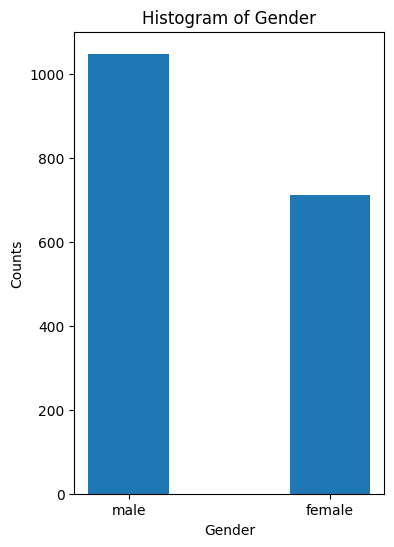

In [ ]:
counts = img_train.sex.value_counts()
plt.figure(figsize=(4, 6))
plt.bar(counts.index, counts.values, width=0.4)
plt.xlabel('Gender')
plt.ylabel('Counts')
plt.title('Histogram of Gender')


In [ ]:
pivot_df = img_train.groupby(['sex', 'dx']).size().unstack(fill_value=0)
df_percentage = pivot_df.div(pivot_df.sum(axis=1), axis=0) * 100

Text(0, 0.5, 'Percentage')

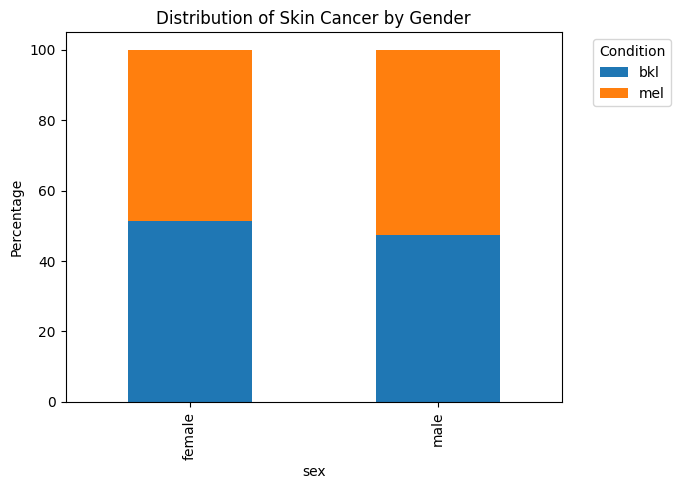

In [ ]:
df_percentage.plot(kind='bar', stacked=True)
plt.legend(title='Condition', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("Distribution of Skin Cancer by Gender")
plt.ylabel('Percentage')

In [ ]:
dataset = HAM10000(csv_file = "/content/gdrive/MyDrive/CSC2529/HAM_train.csv",
                           img_dir = "/content/gdrive/MyDrive/Team_1/Data/HAM10000/HAM10000_images/",

transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ])
)

In [ ]:
train_dl = DataLoader(dataset, batch_size=32, shuffle=True)

In [ ]:
test_set = HAM10000(csv_file = "/content/gdrive/MyDrive/CSC2529/HAM_test.csv",
                          img_dir = "/content/gdrive/MyDrive/Team_1/Data/HAM10000/HAM10000_images/",
                          transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
]))

In [ ]:
test_dl = DataLoader(test_set)

#### Baseline

Using entire training data

In [ ]:
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=weight_decay, betas=(beta1,beta2))

In [ ]:
for epoch in range(10):
  model.train()
  for input, label, gender in train_dl:
    optimizer.zero_grad()
    outputs = model(input)
    loss = criterion(outputs, label)
    loss.backward()
    optimizer.step()

print(f'Loss: {loss.item()}')

Loss: 0.3572191298007965


In [ ]:
acc_female = []
acc_male = []

In [ ]:
model.eval()
with torch.no_grad():
    for inputs, labels, gender in test_dl:
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        correct = 0
        if predicted == labels: correct = 1
        match gender[0]:
          case 'female': acc_female.append(correct)
          case 'male': acc_male.append(correct)

In [ ]:
print(f"For female, the accuracy is {sum(acc_female)/len(acc_female)}")
print(f"For male, the accuracy is {sum(acc_male)/len(acc_male)}")

For female, the accuracy is 0.7028571428571428
For male, the accuracy is 0.7105263157894737


========================================


In [ ]:
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=weight_decay, betas=(beta1,beta2))

In [ ]:
for epoch in range(10):
  model.train()
  for input, label, gender in train_dl:
    optimizer.zero_grad()
    outputs = model(input)
    loss = criterion(outputs, label)
    loss.backward()
    optimizer.step()

print(f'Loss: {loss.item()}')

Loss: 0.4362962543964386


In [ ]:
acc_female = []
acc_male = []
acc_mel = []
acc_bkl = []

In [ ]:
model.eval()
with torch.no_grad():
    for inputs, label, gender in test_dl:
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        correct = 0
        if predicted == labels: correct = 1
        match gender[0]:
          case 'female': acc_female.append(correct)
          case 'male': acc_male.append(correct)

        match label[0]:
          case 0: acc_bkl.append(correct)
          case 1: acc_mel.append(correct)

========================================


In [ ]:
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=weight_decay, betas=(beta1,beta2))

In [ ]:
for epoch in range(10):
  model.train()
  for input, label, gender in train_dl:
    optimizer.zero_grad()
    outputs = model(input)
    loss = criterion(outputs, label)
    loss.backward()
    optimizer.step()

print(f'Loss: {loss.item()}')

Loss: 0.012643975205719471


In [ ]:
acc_mel = []
acc_bkl = []

In [ ]:
model.eval()
with torch.no_grad():
    for inputs, label, gender in test_dl:
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        correct = 0
        if predicted == label: correct = 1
        match label[0]:
          case 0: acc_bkl.append(correct)
          case 1: acc_mel.append(correct)

In [ ]:
print(f"For melanoma, the accuracy is {sum(acc_mel)/len(acc_mel)}")
print(f"For benign keratosis, the accuracy is {sum(acc_bkl)/len(acc_bkl)}")

For melanoma, the accuracy is 0.8364485981308412
For benign keratosis, the accuracy is 0.5814977973568282


#### Imbalanced

In [ ]:
HAM_ori = pd.read_csv("/content/gdrive/MyDrive/CSC2529/HAM_train.csv")

We remove 70\% male to exacerbate the imbalance in the dataset

In [ ]:
n_male = int(len(HAM_ori[HAM_ori['sex'] == 'male']) * 0.7)

In [ ]:
rows_to_remove = HAM_ori[HAM_ori['sex'] == 'male'].sample(n_male).index

In [ ]:
HAM_imbalance_male = HAM_ori.drop(rows_to_remove)

In [ ]:
HAM_imbalance_male.to_csv("/content/gdrive/MyDrive/CSC2529/HAM_imbalance_male.csv")

In [ ]:
img_train = pd.read_csv("/content/gdrive/MyDrive/CSC2529/HAM_imbalance_male.csv")

By removing 70% male from the original data, we nearly double the difference between gender in terms of the percentage to create a severe imbalance

In [ ]:
img_train.sex.value_counts()

female    712
male      315
Name: sex, dtype: int64

Text(0.5, 1.0, 'Histogram of Gender')

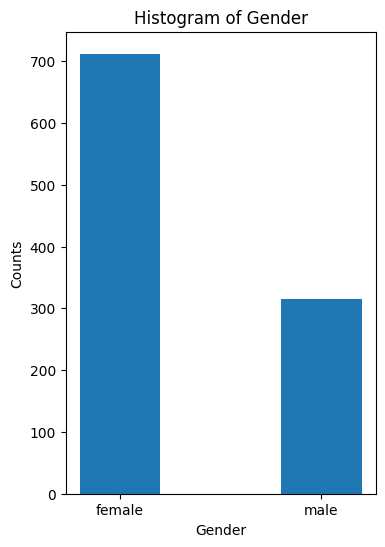

In [ ]:
counts = img_train.sex.value_counts()
plt.figure(figsize=(4, 6))
plt.bar(counts.index, counts.values, width=0.4)
plt.xlabel('Gender')
plt.ylabel('Counts')
plt.title('Histogram of Gender')


In [ ]:
pivot_df = img_train.groupby(['sex', 'dx']).size().unstack(fill_value=0)
df_percentage = pivot_df.div(pivot_df.sum(axis=1), axis=0) * 100

Text(0, 0.5, 'Percentage')

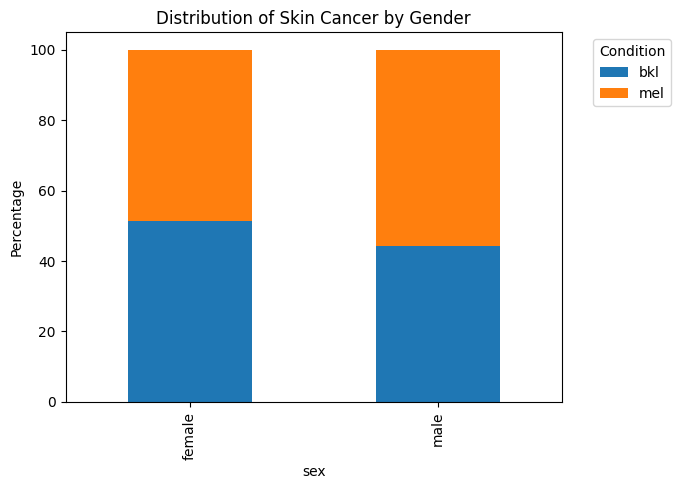

In [ ]:
df_percentage.plot(kind='bar', stacked=True)
plt.legend(title='Condition', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("Distribution of Skin Cancer by Gender")
plt.ylabel('Percentage')

In [ ]:
dataset = HAM10000(csv_file = "/content/gdrive/MyDrive/CSC2529/HAM_imbalance_male.csv",
                           img_dir = "/content/gdrive/MyDrive/Team_1/Data/HAM10000/HAM10000_images/",

transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ])
)

In [ ]:
train_dl = DataLoader(dataset, batch_size=32, shuffle=True)

In [ ]:
len(train_dl)

33

In [ ]:
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=weight_decay, betas=(beta1,beta2))

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 161MB/s]


In [ ]:
for epoch in range(10):
  model.train()
  for input, label, gender in train_dl:
    optimizer.zero_grad()
    outputs = model(input)
    loss = criterion(outputs, label)
    loss.backward()
    optimizer.step()
print(f'Loss: {loss.item()}')

Loss: 0.10409633070230484


In [ ]:
acc_female = []
acc_male = []

In [ ]:
model.eval()
with torch.no_grad():
    for inputs, labels, gender in test_dl:
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        correct = 0
        if predicted == labels: correct = 1
        match gender[0]:
          case 'female': acc_female.append(correct)
          case 'male': acc_male.append(correct)

In [ ]:
print(f"For female, the accuracy is {sum(acc_female)/len(acc_female)}")
print(f"For male, the accuracy is {sum(acc_male)/len(acc_male)}")

For female, the accuracy is 0.6514285714285715
For male, the accuracy is 0.5451127819548872


In [ ]:
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=weight_decay, betas=(beta1,beta2))

In [ ]:
for epoch in range(10):
  model.train()
  for input, label, gender in train_dl:
    optimizer.zero_grad()
    outputs = model(input)
    loss = criterion(outputs, label)
    loss.backward()
    optimizer.step()

print(f'Loss: {loss.item()}')

Loss: 0.04324306920170784


In [ ]:
acc_mel = []
acc_bkl = []

In [ ]:
model.eval()
with torch.no_grad():
    for inputs, label, gender in test_dl:
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        correct = 0
        if predicted == label: correct = 1
        match label[0]:
          case 0: acc_bkl.append(correct)
          case 1: acc_mel.append(correct)

In [ ]:
print(f"For melanoma, the accuracy is {sum(acc_mel)/len(acc_mel)}")
print(f"For benign keratosis, the accuracy is {sum(acc_bkl)/len(acc_bkl)}")

For melanoma, the accuracy is 0.8551401869158879
For benign keratosis, the accuracy is 0.5638766519823789


## GAN

In [ ]:
HAM_imbalance_male = pd.read_csv("/content/gdrive/MyDrive/CSC2529/HAM_imbalance_male.csv")

In [ ]:
GAN_male_bkl = pd.read_csv("/content/gdrive/MyDrive/CSC2529/GAN_aug_male_bkl.csv")
GAN_male_mel = pd.read_csv("/content/gdrive/MyDrive/CSC2529/GAN_aug_male_mel.csv")

In [ ]:
GAN_total = pd.concat([HAM_imbalance_male, GAN_male_bkl, GAN_male_mel])

In [ ]:
dataset = HAM10000(csv_file = "/content/gdrive/MyDrive/CSC2529/GAN_total.csv",
                           img_dir = "/content/gdrive/MyDrive/Team_1/Data/HAM10000/HAM10000_images/",

transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ])
)

In [ ]:
train_dl = DataLoader(dataset, batch_size=32, shuffle=True)

In [ ]:
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=weight_decay, betas=(beta1,beta2))

In [ ]:
for epoch in range(10):
  model.train()
  for input, label, gender in train_dl:
    optimizer.zero_grad()
    outputs = model(input)
    loss = criterion(outputs, label)
    loss.backward()
    optimizer.step()

print(f'Loss: {loss.item()}')

Loss: 0.0013814172707498074


In [ ]:
acc_female = []
acc_male = []
acc_mel = []
acc_bkl = []

In [ ]:
model.eval()
with torch.no_grad():
    for inputs, labels, gender in test_dl:
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        correct = 0
        if predicted == labels: correct = 1
        match gender[0]:
          case 'female': acc_female.append(correct)
          case 'male': acc_male.append(correct)
        if labels[0] == 0: acc_bkl.append(correct)
        else: acc_mel.append(correct)

In [ ]:
print(f"For female, the accuracy is {sum(acc_female)/len(acc_female)}")
print(f"For male, the accuracy is {sum(acc_male)/len(acc_male)}")

For female, the accuracy is 0.6971428571428572
For male, the accuracy is 0.6616541353383458


++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

In [ ]:
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=weight_decay, betas=(beta1,beta2))

In [ ]:
for epoch in range(10):
  model.train()
  for input, label, gender in train_dl:
    optimizer.zero_grad()
    outputs = model(input)
    loss = criterion(outputs, label)
    loss.backward()
    optimizer.step()

print(f'Loss: {loss.item()}')

Loss: 0.2748543918132782


In [ ]:
acc_mel = []
acc_bkl = []

In [ ]:
model.eval()
with torch.no_grad():
    for inputs, label, gender in test_dl:
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        correct = 0
        if predicted == label: correct = 1
        match label[0]:
          case 0: acc_bkl.append(correct)
          case 1: acc_mel.append(correct)

In [ ]:
print(f"For melanoma, the accuracy is {sum(acc_mel)/len(acc_mel)}")
print(f"For benign keratosis, the accuracy is {sum(acc_bkl)/len(acc_bkl)}")

For melanoma, the accuracy is 0.8504672897196262
For benign keratosis, the accuracy is 0.5286343612334802
